Missing Value Overview in Test Set:


,Missing Count,Missing Ratio (%)
PoolQC,1456,99.79
MiscFeature,1408,96.50
Alley,1352,92.67
Fence,1169,80.12
MasVnrType,894,61.27
FireplaceQu,730,50.03
LotFrontage,227,15.56
GarageQual,78,5.35
GarageCond,78,5.35
GarageYrBlt,78,5.35


Group-based Std Dev for LotFrontage in Test Set:


,Grouping Column,# of Groups,Avg Group Std Dev,Max Group Std Dev
0,Neighborhood,25,16.14,29.22
2,MSZoning,5,18.90,27.40
3,LotConfig,5,24.88,36.36
1,Street,2,32.96,43.68


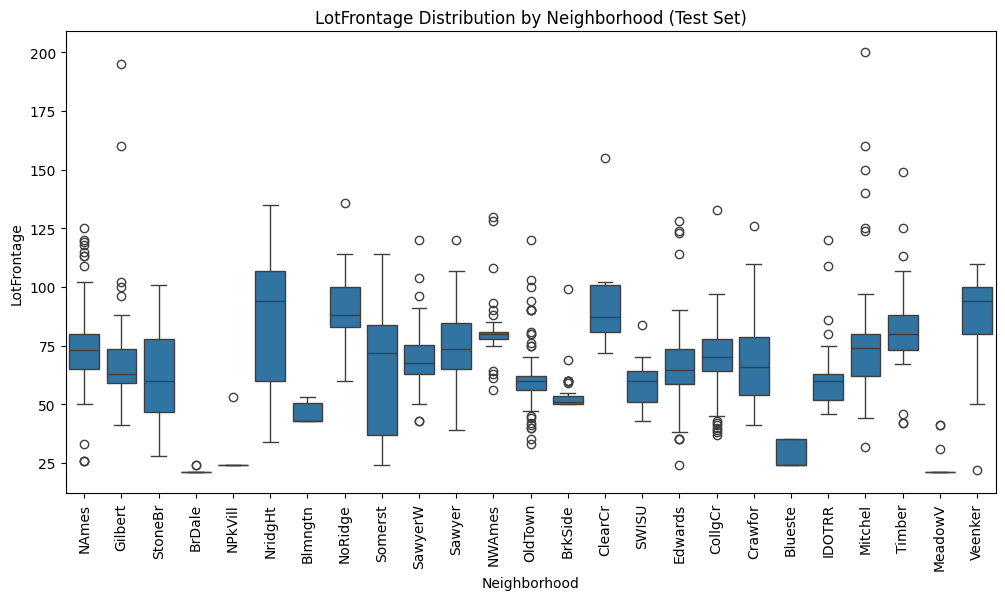

In [1]:
import pandas as pd

# Load test data
test = pd.read_csv("test.csv")

# Step 1: Overview of missing data
missing_data = test.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_ratio = (missing_data / len(test)) * 100

missing_overview = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Ratio (%)': missing_ratio.round(2)
})

print("Missing Value Overview in Test Set:")
display(missing_overview)

# Candidate grouping columns
grouping_candidates = ["Neighborhood", "Street", "MSZoning", "LotConfig"]

comparison = []

for col in grouping_candidates:
    group_stats = test.groupby(col)["LotFrontage"].std()
    avg_std = group_stats.mean()
    max_std = group_stats.max()
    num_groups = group_stats.shape[0]
    
    comparison.append({
        "Grouping Column": col,
        "# of Groups": num_groups,
        "Avg Group Std Dev": round(avg_std, 2),
        "Max Group Std Dev": round(max_std, 2)
    })

comparison_df = pd.DataFrame(comparison).sort_values(by="Avg Group Std Dev")
print("Group-based Std Dev for LotFrontage in Test Set:")
display(comparison_df)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='LotFrontage', data=test)
plt.xticks(rotation=90)
plt.title('LotFrontage Distribution by Neighborhood (Test Set)')
plt.show()


In [2]:
# ➤ 1. Fill high-missing categorical features with "None"
high_missing_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "MasVnrType", "FireplaceQu"]
test[high_missing_cols] = test[high_missing_cols].fillna("None")

# ➤ 2. Impute LotFrontage using median per Neighborhood
neighborhood_medians = test.groupby("Neighborhood")["LotFrontage"].median()
test["LotFrontage"] = test.apply(
    lambda row: neighborhood_medians[row["Neighborhood"]]
    if pd.isnull(row["LotFrontage"]) else row["LotFrontage"],
    axis=1
)


In [3]:
#  1. GarageYrBlt: Create missing flag, then fill with 0
test["GarageYrBlt_missing"] = test["GarageYrBlt"].isnull().astype(int)
test["GarageYrBlt"] = test["GarageYrBlt"].fillna(0)

#  2. Garage categorical features: fill missing with "None"
garage_cat_features = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]
for feature in garage_cat_features:
    test[feature] = test[feature].fillna("None")

# 3. MasVnrArea: Create missing flag, then fill with 0
test["MasVnrArea_missing"] = test["MasVnrArea"].isnull().astype(int)
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)

# 4. Basement categorical features
bsmt_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

# Step 1: Find rows where all 5 basement features are missing → clearly no basement
no_bsmt_mask = test[bsmt_features].isnull().all(axis=1)
test.loc[no_bsmt_mask, bsmt_features] = 'None'

# Step 2: Fill remaining missing values with mode (most common value)
for col in bsmt_features:
    if test[col].isnull().sum() > 0:
        mode_val = test[col].mode()[0]
        test[col] = test[col].fillna(mode_val)

In [4]:
for col in ["Electrical", "KitchenQual", "SaleType"]:
    if test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(test[col].mode()[0])



In [5]:
# Overview of missing data again
missing_data = test.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_ratio = (missing_data / len(test)) * 100

missing_overview = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Ratio (%)': missing_ratio.round(2)
})

print("Missing Value Overview in Test Set:")
display(missing_overview)

Missing Value Overview in Test Set:


,Missing Count,Missing Ratio (%)
MSZoning,4,0.27
Utilities,2,0.14
Functional,2,0.14
BsmtHalfBath,2,0.14
BsmtFullBath,2,0.14
BsmtFinSF1,1,0.07
Exterior2nd,1,0.07
Exterior1st,1,0.07
BsmtFinSF2,1,0.07
TotalBsmtSF,1,0.07


In [6]:
# Categorical: fill with mode
for col in ["MSZoning", "Utilities", "Functional", "Exterior1st", "Exterior2nd"]:
    mode_val = test[col].mode()[0]
    test[col] = test[col].fillna(mode_val)

# Numerical: fill with 0
num_fill_zero = ["BsmtHalfBath", "BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2",
                 "TotalBsmtSF", "BsmtUnfSF", "GarageCars", "GarageArea"]

test[num_fill_zero] = test[num_fill_zero].fillna(0)


In [8]:
# Final check: confirm no missing values remain
assert test.isnull().sum().sum() == 0, "There are still missing values in the test set."

# Save the cleaned test set
test.to_csv("test_clean_data.csv", index=False)
print("Cleaned test set saved to 'test_clean_data.csv'")


Cleaned test set saved to 'test_clean_data.csv'
